<a href="https://colab.research.google.com/github/EmaMule/Change-Detection/blob/main/TesinaLABIAGI_MULE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir("./drive/MyDrive/LabIAGITESINA_MULE/data")

In [ ]:
!ls

clnet_model.py
FC_Siam_Diff_Att_Ga.py
FCSNN.py
fresunet.py
MiaSiamese
MyUnet-best_epoch-0_fm-0.4708108057104575.pth.tar
MyUnet-best_epoch-0_loss-0.2995803952217102.pth.tar
MyUnet-best_epoch-13_loss-0.21256349980831146.pth.tar
MyUnet-best_epoch-15_fm-0.5719721907951788.pth.tar
MyUnet-best_epoch-15_loss-0.23979981243610382.pth.tar
MyUnet-best_epoch-16_loss-0.23160570859909058.pth.tar
MyUnet-best_epoch-17_fm-0.5960514927050408.pth.tar
MyUnet-best_epoch-19_loss-0.22107161581516266.pth.tar
MyUnet-best_epoch-2_fm-0.4739374102924014.pth.tar
MyUnet-best_epoch-2_loss-0.25411805510520935.pth.tar
MyUnet-best_epoch-4_fm-0.5351433746881302.pth.tar
MyUnet-best_epoch-7_fm-0.5956205022602261.pth.tar
MyUnet-best_epoch-7_loss-0.2411726415157318.pth.tar
MyUnet-best_epoch-9_loss-0.2242956906557083.pth.tar
MyUnet-brasilia.png
MyUnet-chongqing.png
MyUnet-dubai.png
MyUnet-last_epoch.pth.tar
MyUnet-lasvegas.png
MyUnet-milano.png
MyUnet-montpellier.png
MyUnet-norcia.png
MyUnet.py
MyUnet-rio.png
MyUnet-saclay_w

Immagine della rete siamese del paper che ho preso come riferimento. Interessato a causa delle performance dichiarate di f1-score e accuracy.
Dichiarati (97% di f1-score su WHUS-CD).

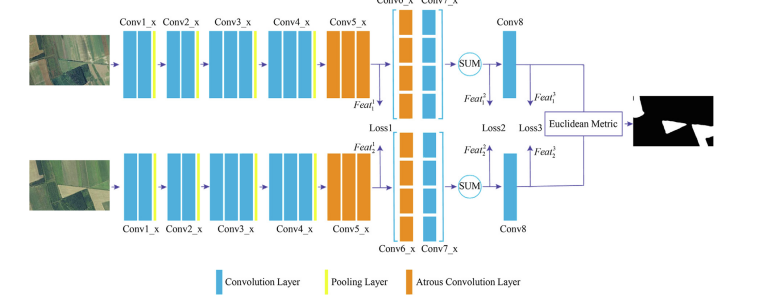

Import di tutti i moduli utilizzati durante il lavoro, sono presenti tra queste alcuni modelli implementati nel paper originale. L'idea del mio lavoro è stata quella di implementare una SiameseNet e una generica Unet per effettuare un confronto tra le due implementazioni.

In [ ]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr

#from unet import Unet
from siamunet_conc import SiamUnet_conc
from siamunet_diff import SiamUnet_diff
from fresunet import FresUNet
from FCSNN import SiameseNet
from MyUnet import MyUnet
from FC_Siam_Diff_Att_Ga import FC_Siam_diff_Att_GA
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import time
import warnings
from pprint import pprint
import albumentations as A
import re
import csv

print('IMPORT OK')

IMPORT OK


Definizione delle variabili globali.

In [ ]:
# Global Variables' Definitions

PATH_TO_DATASET = './OSCD-Dataset/'
IS_PROTOTYPE = False

FP_MODIFIER = 10 # Tuning parameter, use 1 if unsure

BATCH_SIZE = 16
PATCH_SIDE = 96
N_EPOCHS = 50

NORMALISE_IMGS = True

TRAIN_STRIDE = int(PATCH_SIDE/2) - 1

TYPE = 3 # 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

DATA_AUG = True

CUDA=torch.cuda.is_available()

RECUPERO_EPOCHES=True

current_dir = os.getcwd()

print('DEFINIZIONI OK')

DEFINIZIONI OK


Definizione di funzioni necessarie a caricare correttamente le immagini.

Elenco delle bande presenti nel dataset e catturate dal satellite Sentinel-2:

* r: Banda rossa (Red, B04)
* g: Banda verde (Green, B03)
* b: Banda blu (Blue, B02)
* nir: Banda NIR (Near Infrared, B08)
* ir1: Banda infrarossa 1 (SWIR1, B05)
* ir2: Banda infrarossa 2 (SWIR2, B06)
* ir3: Banda infrarossa 3 (SWIR3, B07)
* nir2: Banda NIR 2 (Near Infrared 2, B8A)
* swir2: Banda SWIR 2 (Shortwave Infrared 2, B11)
* swir3: Banda SWIR 3 (Shortwave Infrared 3, B12)
* uv: Banda ultravioletta (Ultraviolet, B01)
* wv: Banda "water vapor" (Water Vapor, B09)
* swirc: Banda SWIR "cirrus" (Shortwave Infrared Cirrus, B10)

In [ ]:
def adjust_shape(I, s):
    """Aggiusta la shape del tensore I dato in input con le dimensioni di s."""

    #taglia l'immagine se l'immagine supera i limiti imposti da s
    I = I[:s[0],:s[1]]
    si = I.shape

    #effettua il padding se necessario
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])

    return np.pad(I,((0,p0),(0,p1)),'edge')


def read_sentinel_img(path):
    """Lettura di una immagine in formato RGB"""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")

    I = np.stack((r,g,b),axis=2).astype('float')

    #normalizza l'immagine
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_4(path):
    """Lettura di una immagine in formato RGB-NiR"""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    #nir è la banda near-infrared
    nir = io.imread(path + im_name + "B08.tif")

    I = np.stack((r,g,b,nir),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq20(path):
    """Lettura di una immagine che usufruisce delle bande con risoluzione minore uguale a 20m"""
    im_name = os.listdir(path)[0][:-7]

    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")

    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)

    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq60(path):
    """Apertura di una immagine che usufruisce di tutte le bande"""
    im_name = os.listdir(path)[0][:-7]

    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")

    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)

    uv = adjust_shape(zoom(io.imread(path + im_name + "B01.tif"),6),s)
    wv = adjust_shape(zoom(io.imread(path + im_name + "B09.tif"),6),s)
    swirc = adjust_shape(zoom(io.imread(path + im_name + "B10.tif"),6),s)

    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3,uv,wv,swirc),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_trio(path):
    """Lettura della tripla formata dall'immagine 1, immagine 2 e change map."""
#     read images
    if TYPE == 0:
        I1 = read_sentinel_img(path + '/imgs_1/')
        I2 = read_sentinel_img(path + '/imgs_2/')
    elif TYPE == 1:
        I1 = read_sentinel_img_4(path + '/imgs_1/')
        I2 = read_sentinel_img_4(path + '/imgs_2/')
    elif TYPE == 2:
        I1 = read_sentinel_img_leq20(path + '/imgs_1/')
        I2 = read_sentinel_img_leq20(path + '/imgs_2/')
    elif TYPE == 3:
        I1 = read_sentinel_img_leq60(path + '/imgs_1/')
        I2 = read_sentinel_img_leq60(path + '/imgs_2/')

    cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0

    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')


    return I1, I2, cm



def reshape_for_torch(I):
    """Reshaping per esprimere le immagini nelle coordinate di pytorch"""
#     out = np.swapaxes(I,1,2)
#     out = np.swapaxes(out,0,1)
#     out = out[np.newaxis,:]
    out = I.transpose((2, 0, 1))
    return torch.from_numpy(out)


#definizione della classe incaricata al load del training set e del test set

class ChangeDetectionDataset(Dataset):
    """Change Detection dataset class, used for both training and test data."""

    def __init__(self, path, train = True, patch_side = 96, stride = None, use_all_bands = False, transform=None):
        """
        Args:
            csv_file (string): percorso al file csv con le annotazioni su quali immagini fanno parte del training e quali del test.
            root_dir (string): Directory con tutte le immagini.
            transform (callable, optional): transform opzionale da applicare ad un sample.
            stride: un intero per specificare quanti elementi saltare
        """

        # basics
        self.transform = transform
        self.path = path
        self.patch_side = patch_side
        if not stride:
            self.stride = 1
        else:
            self.stride = stride

        if train:
            fname = 'train.txt'
        else:
            fname = 'test.txt'

        #nomi delle località contenuti nel train / test
        self.names = read_csv(path + fname).columns
        self.n_imgs = self.names.shape[0]

        n_pix = 0
        true_pix = 0

        # load images
        self.imgs_1 = {} #dizionario di immagini pre-change
        self.imgs_2 = {} #dizionario di immagini post-change
        self.change_maps = {}#dizionario di change maps
        self.n_patches_per_image = {} #dizionario di n_patch
        self.n_patches = 0
        self.patch_coords = [] #lista di coordinate
        for im_name in tqdm(self.names):
            # carica e salva ogni immagine
            I1, I2, cm = read_sentinel_img_trio(self.path + im_name)
            self.imgs_1[im_name] = reshape_for_torch(I1)
            self.imgs_2[im_name] = reshape_for_torch(I2)
            self.change_maps[im_name] = cm

            s = cm.shape
            n_pix += np.prod(s)
            true_pix += cm.sum()

            # calcola il numero di patch
            s = self.imgs_1[im_name].shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2
            self.n_patches_per_image[im_name] = n_patches_i
            self.n_patches += n_patches_i

            # genera coordinate path
            for i in range(n1):
                for j in range(n2):
                    # coordinates in (x1, x2, y1, y2)
                    current_patch_coords = (im_name,
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side],
                                    [self.stride*(i + 1), self.stride*(j + 1)])
                    self.patch_coords.append(current_patch_coords)

        #inizializzazione dei pesi
        #decommentare per usare:
        self.weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]
        """self.weights = np.array([ 1 , (n_pix - true_pix) / true_pix])
        self.weights = 2 * self.weights/self.weights.sum()"""


    #metodo per reperire un immagine attraverso il suo nome
    def get_img(self, im_name):
        return self.imgs_1[im_name], self.imgs_2[im_name], self.change_maps[im_name]

    def __len__(self):
        return self.n_patches

    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        im_name = current_patch_coords[0]
        limits = current_patch_coords[1]
        centre = current_patch_coords[2]

        I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]

        label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        label = torch.from_numpy(1*np.array(label)).float()

        sample = {'I1': I1, 'I2': I2, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample



print("UTILS OK")

UTILS OK


FUNZIONI DI DATA AUGMENTATION

In [ ]:
class RandomFlip(object):
    """Ribalta randomicamente una immagine in un sample, da ***implementare il ribaltamento verticale oltre che orizzontale***"""

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']

        if random.random() > 0.5:
            #ribalta lungo l'asse y, quindi orizzontalmente
            I1 =  I1.numpy()[:,:,::-1].copy()
            I1 = torch.from_numpy(I1)
            I2 =  I2.numpy()[:,:,::-1].copy()
            I2 = torch.from_numpy(I2)
            label =  label.numpy()[:,::-1].copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}



class RandomRot(object):
    """Ruota randomicamente una immagine in un sample."""

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']

        n = random.randint(0, 3)
        if n:
          #implementata solo la rotazione a 90 gradi, forse da implementare anche di meglio
            I1 =  sample['I1'].numpy()
            I1 = np.rot90(I1, n, axes=(1, 2)).copy()
            I1 = torch.from_numpy(I1)
            I2 =  sample['I2'].numpy()
            I2 = np.rot90(I2, n, axes=(1, 2)).copy()
            I2 = torch.from_numpy(I2)
            label =  sample['label'].numpy()
            label = np.rot90(label, n, axes=(0, 1)).copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}
import random

class RandomCut(object):
    """Effettua un taglio casuale di un'immagine in un campione."""

    def __init__(self, p=0.5, min_cut_size=0.1, max_cut_size=0.5):
        self.p = p
        self.min_cut_size = min_cut_size
        self.max_cut_size = max_cut_size

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']

        if random.random() < self.p:
            height, width = I1.size(1), I1.size(2)
            cut_size = random.uniform(self.min_cut_size, self.max_cut_size)

            cut_height = int(height * cut_size)
            cut_width = int(width * cut_size)

            # Calcola le coordinate del punto di inizio del taglio casuale
            start_x = random.randint(0, width - cut_width)
            start_y = random.randint(0, height - cut_height)

            # Applica il taglio casuale all'immagine
            I1[:, start_y:start_y+cut_height, start_x:start_x+cut_width] = 0
            I2[:, start_y:start_y+cut_height, start_x:start_x+cut_width] = 0
            label[start_y:start_y+cut_height, start_x:start_x+cut_width] = 0

        return {'I1': I1, 'I2': I2, 'label': label}

class RandomColor(object):
    """Modifica casualmente il colore di un'immagine multiband in un campione."""

    def __init__(self, brightness_limit=0.2, contrast_limit=0.2, saturation_limit=0.2, hue_shift_limit=10):
        self.transform = A.Compose([
            A.ToFloat(),
            A.RandomBrightnessContrast(p=1),
            A.HueSaturationValue(p=1),
            A.Normalize(max_pixel_value=1.0, always_apply=True)
        ])

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']

        # Converte le immagini in formato numpy float32
        I1_np = np.transpose(I1.numpy(), (1, 2, 0)).astype(np.float32)
        I2_np = np.transpose(I2.numpy(), (1, 2, 0)).astype(np.float32)

        # Applica la trasformazione del colore separatamente su ciascun canale
        transformed_I1 = self.transform(image=I1_np)['image']
        transformed_I2 = self.transform(image=I2_np)['image']

        # Converte le immagini di nuovo in formato tensoriale
        transformed_I1 = torch.from_numpy(np.transpose(transformed_I1, (2, 0, 1)))
        transformed_I2 = torch.from_numpy(np.transpose(transformed_I2, (2, 0, 1)))

        return {'I1': transformed_I1, 'I2': transformed_I2, 'label': label}



class RandomContrast(object):
    """Modifica casualmente il contrasto di un'immagine in un campione."""

    def __init__(self, contrast_limit=0.2):
        self.transform = A.RandomContrast(limit=contrast_limit)

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']

        # Converte le immagini in formato numpy
        I1_np = np.transpose(I1.numpy(), (1, 2, 0))
        I2_np = np.transpose(I2.numpy(), (1, 2, 0))

        # Applica la trasformazione del contrasto utilizzando Albumentations
        transformed_I1 = self.transform(image=I1_np)['image']
        transformed_I2 = self.transform(image=I2_np)['image']

        # Converte le immagini di nuovo in formato tensoriale
        transformed_I1 = torch.from_numpy(np.transpose(transformed_I1, (2, 0, 1)))
        transformed_I2 = torch.from_numpy(np.transpose(transformed_I2, (2, 0, 1)))

        return {'I1': transformed_I1, 'I2': transformed_I2, 'label': label}

print('UTILS OK')

UTILS OK


Carica il dataset, effettuando o meno data-augmentation che nell'ambito di questodataset essendo le immagini relativamente poche è buona pratica.

In [ ]:
#provo senza randomContrast ,RandomCut(p=0.4,min_cut_size=0.6,max_cut_size=0.9)
if DATA_AUG:
    data_transform = tr.Compose([RandomFlip(), RandomRot()])
else:
    data_transform = None




train_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = True, stride = TRAIN_STRIDE, transform=data_transform)
if CUDA:
  weights = torch.FloatTensor(train_dataset.weights).cuda()
else:
  weights = torch.FloatTensor(train_dataset.weights).cpu() #inizializzazione pesi considerando quanto una classe è presente rispetto all'altra
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2) #num_workers da settare a seconda della architettura

test_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = False, stride = TRAIN_STRIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2) #consigliato 2 nell'ambiente Colab


print('DATASETS OK')

100%|██████████| 10/10 [03:22<00:00, 20.27s/it]

DATASETS OK


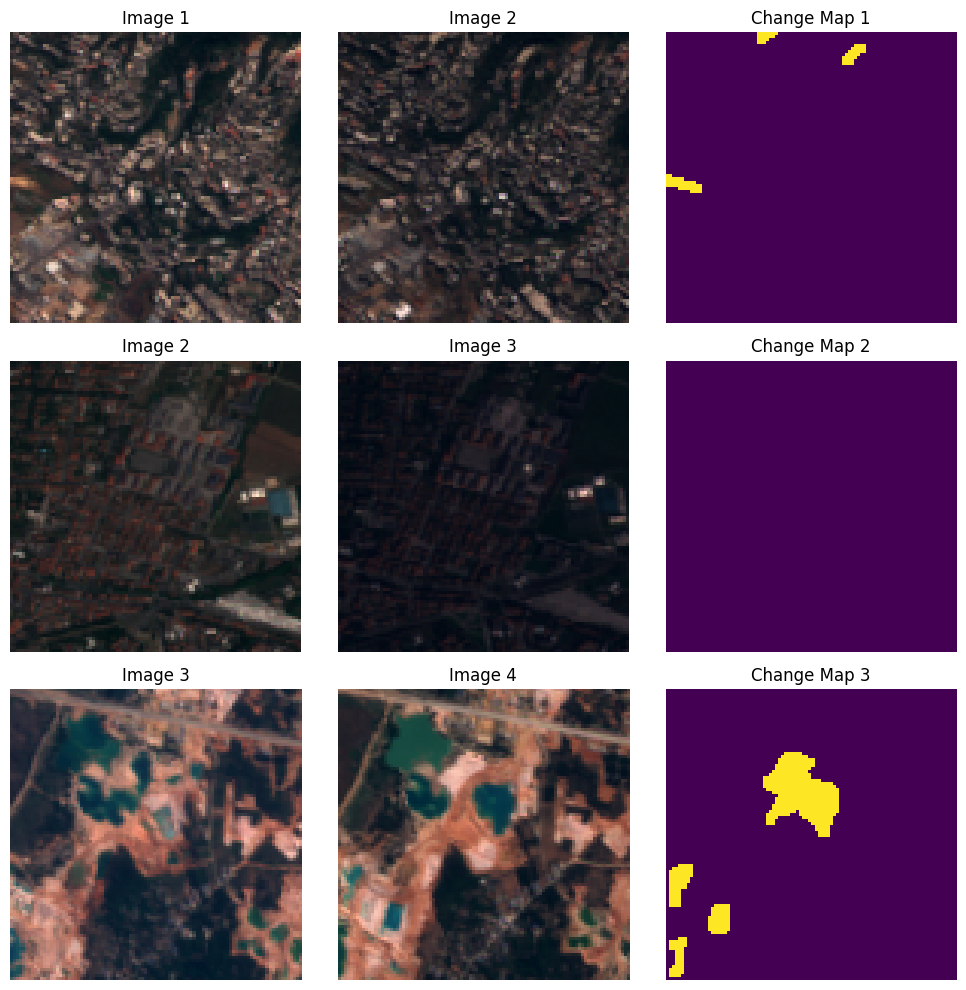

In [ ]:
import random
import matplotlib.pyplot as plt

# Genera tre indici casuali
random_indices = random.sample(range(len(train_dataset)), 3)

# Crea il subplot con 3 righe e 3 colonne
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Itera sui campioni casuali e visualizzali
for i, idx in enumerate(random_indices):
    # Ottenere il campione dal dataset
    sample = train_dataset[idx]
    I1 = sample['I1']
    I2 = sample['I2']
    change_map = sample['label']

    # Riduci il numero di canali a 3 per visualizzare le immagini
    I1 = I1[:3]
    I2 = I2[:3]

    # Normalizza i valori dei pixel nell'intervallo [0, 1]
    I1 = (I1 - I1.min()) / (I1.max() - I1.min())
    I2 = (I2 - I2.min()) / (I2.max() - I2.min())

    # Visualizza le immagini e la mappa di cambio nei subplot corrispondenti
    axes[i, 0].imshow(I1.permute(1, 2, 0).numpy())
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(I2.permute(1, 2, 0).numpy())
    axes[i, 1].set_title(f'Image {i+2}')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(change_map)
    axes[i, 2].set_title(f'Change Map {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
class FocalContrastiveLoss(torch.nn.Module):
  def __init__(self, margin, alpha, tau):
    super(FocalContrastiveLoss, self).__init__()
    self.m = margin
    self.a = alpha
    self.t = tau
  def forward(self, output1, output2, label):
    distance = F.pairwise_distance(input1, input2, p = 2)
    e = torch.clamp(distance, min = self.t, max = self.m)
    neg = torch.clamp(distance - self.t, min = 0.0)
    pos = torch.clamp(self.m - distance, min = 0.0)
    loss = (1.0-label)*neg*self.a*(-torch.log((self.margin + self.t-e)/self.m)) + label*pos*(1-self.a)*(-torch.log(e/self.m))
    return torch.mean(loss)

LOSS UTILIZZATE:

$\text{BCE Loss} = -\frac{1}{N}\sum_{i=1}^{N} [y_i \cdot \log(p_i) + (1-y_i) \cdot \log(1-p_i)]$
**UTILIZZATA CON SIGMOIDE**


$\text{NLL Loss} = -\frac{1}{N}\sum_{i=1}^{N} \log(p_i)$ **UTILIZZATA CON LOGSOFTMAX**


$\text{FCE Loss} = \frac{1}{N}\sum_{i=1}^{N} \left( (1 - \text{label}_i) \cdot \text{neg}_i \cdot \alpha \cdot \left(-\log\left(\frac{\text{margin} + \text{t} - e_i}{\text{margin}}\right)\right) + \text{label}_i \cdot \text{pos}_i \cdot (1 - \alpha) \cdot \left(-\log\left(\frac{e_i}{\text{margin}}\right)\right) \right)$ **UTILIZZATA CON SIGMOIDE**


In [ ]:
#net, net_name = SiameseNet(13, 2), 'SiameseNet'
net,net_name=MyUnet(2*13,2),'MyUnet'

if CUDA:
  net.cuda()
else:
  net.cpu()

#definizione della loss, da sperimentare la ContrastiveLoss, sia del paper che quella pre-implementata
criterion = nn.NLLLoss(weight=weights)
#criterion=FocalContrastiveLoss(weight=weights,1,0.1,0.1) funzione di loss modificata del paper
#criterion=nn.BCELoss(pos_weight=weights)

print('NETWORK OK')

NETWORK OK


In [ ]:
#conteggio dei parametri, per avere una stima del training time/capacità di apprendimento della rete
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(net))

Number of trainable parameters: 3707554


In [ ]:
# Definisci il percorso del file CSV
csv_file_path = f'performance_{net_name}.csv'
column_names = [
    'Epoch',
    'Train Loss',
    'Train Accuracy',
    'Train No Change Accuracy',
    'Train Change Accuracy',
    'Train Precision',
    'Train Recall',
    'Train F1',
    'Test Loss',
    'Test Accuracy',
    'Test No Change Accuracy',
    'Test Change Accuracy',
    'Test Precision',
    'Test Recall',
    'Test F1',
]

# Apri il file CSV in modalità scrittura e scrivi i nomi delle colonne
if not os.path.isfile(csv_file_path):
  with open(csv_file_path, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)

      # Scrivi i nomi delle colonne nel file CSV
      writer.writerow(column_names)
else:
  print("FILE READY")

FILE READY


Codice necessario per recuperare il training in caso di interruzioni improvvise (BEST_EPOCHES)

In [ ]:
epoch_index_init=0
if RECUPERO_EPOCHES:
  # define a regular expression pattern to match the filename format

  pattern = net_name + r"-best_epoch-(\d+)(_fm|_loss)-(\d+\.\d+)\.pth\.tar"

  # compile the pattern into a regular expression object
  regex = re.compile(pattern)

  # list all the files in the directory
  files = os.listdir("./")

  epoch_fm_tuple = [(int(regex.search(f).group(1)), str(regex.search(f).group(2)),str(regex.search(f).group(3))) for f in files if regex.search(f)]

  # select the latest epoch number and the corresponding filename
  if epoch_fm_tuple:
    best_epoch, tipo, best_tipo = max(epoch_fm_tuple, key=lambda x: x[0])
    latest_file = net_name+f"-best_epoch-{best_epoch}{tipo}-{best_tipo}.pth.tar"

  # initialize epoch_index to the minimum of best_epoch and 50
    epoch_index_init = min(best_epoch, N_EPOCHS) +1
    if CUDA:
      net.load_state_dict(torch.load(latest_file))
    else:
      net.load_state_dict(torch.load(latest_file,map_location=torch.device('cpu')))
print(epoch_index_init)

20


RECUPERO LAST_EPOCHES DELLA RETE

In [ ]:
epoch_index_init=0
latest_file=f'{net_name}-last_epoch.pth.tar'
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
if RECUPERO_EPOCHES:
  if os.path.exists(latest_file):
    checkpoint = torch.load(latest_file)
    if CUDA:
      epoch_index_init=checkpoint['epoch']+1
      net.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
      epoch_index_init=checkpoint['epoch']+1
      net.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(epoch_index_init)

27


FocalContrastiveLoss la loss che vorrei implementare.

Codice per il training della rete, implementazione di un metodo train e un metodo test. Il primo necessario addestra, il secondo serve a valutare le performance della rete sul train e sul test durante le iterazoni. Aggiungere salvataggio optimizer e load.

In [ ]:
def train(n_epochs = N_EPOCHS, save = True):
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    epoch_train_change_accuracy = 0
    epoch_train_nochange_accuracy = 0
    epoch_train_precision = 0
    epoch_train_recall = 0
    epoch_train_Fmeasure = 0
    epoch_test_loss = 0
    epoch_test_accuracy = 0
    epoch_test_change_accuracy = 0
    epoch_test_nochange_accuracy = 0
    epoch_test_precision = 0
    epoch_test_recall = 0
    epoch_test_Fmeasure = 0

#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0

    lss = 1000
    best_lss = 1000

    #plt.figure(num=1)
    #plt.figure(num=2)
    #plt.figure(num=3)
    #optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)


    #scheduler è da scegliere se utilizzarlo o meno, potrebbe essere molto utile per evitare oscillazioni così come la rovina se il lr è di per sè molto basso
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

    for epoch_index in tqdm(range(epoch_index_init,n_epochs)):
        #setta la rete in modalità train
        net.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))
        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
        for batch in tqdm(train_loader):
          if CUDA:
            I1 = Variable(batch['I1'].float().cuda())
            I2 = Variable(batch['I2'].float().cuda())
            label = torch.squeeze(Variable(batch['label'].cuda()))
          else:
            I1 = Variable(batch['I1'].float().cpu())
            I2 = Variable(batch['I2'].float().cpu())
            label = torch.squeeze(Variable(batch['label'].cpu()))
            #azzeramento dei gradienti per evitare che l'aggiornamento dei gradienti di un precedente batch influenzi l'aggiornamento di quello successivo
            optimizer.zero_grad()
            output = net(I1, I2)
            #calcolo della loss in funzione della change map
            loss = criterion(output, label.long())
            #print(loss)
            #backpropagation dell'errore tra i layer della rete
            loss.backward()
            #aggiorna i pesi della rete dopo la backpropagation per ottimizzare la funzione di loss minimizzandola
            optimizer.step()
            #azzera la cache di cuda per evitare problemi di memoria (limite dell'ambiente)
            torch.cuda.empty_cache()
            del I1,I2,label

        #ad ogni epoch lo scheduler fa uno step, da valutare il suo utilizzo
        #scheduler.step()
        epoch_train_loss, epoch_train_accuracy, cl_acc, pr_rec = test(train_dataset)
        epoch_train_nochange_accuracy = cl_acc[0]
        epoch_train_change_accuracy = cl_acc[1]
        epoch_train_precision= pr_rec[0]
        epoch_train_recall= pr_rec[1]
        epoch_train_Fmeasure= pr_rec[2]

        epoch_test_loss, epoch_test_accuracy, cl_acc, pr_rec = test(test_dataset)
        epoch_test_nochange_accuracy = cl_acc[0]
        epoch_test_change_accuracy = cl_acc[1]
        epoch_test_precision = pr_rec[0]
        epoch_test_recall= pr_rec[1]
        epoch_test_Fmeasure= pr_rec[2]
        if epoch_test_loss<best_lss:
          best_lss=epoch_test_loss
          model_name = f'{net_name}-best_epoch-{epoch_index}_loss-{best_lss}.pth.tar'
          save_path = os.path.join(current_dir, model_name)
          torch.save(net.state_dict(), save_path)
        if epoch_test_Fmeasure>best_fm:
          best_fm=epoch_test_Fmeasure
          model_name = f'{net_name}-best_epoch-{epoch_index}_fm-{best_fm}.pth.tar'
          save_path = os.path.join(current_dir, model_name)
          torch.save(net.state_dict(), save_path)
        # Apri il file CSV in modalità append
        model_name = latest_file
        save_path = os.path.join(current_dir, model_name)
        torch.save({"model_state_dict": net.state_dict(), "optimizer_state_dict": optimizer.state_dict(),"epoch": epoch_index}, save_path)
        with open(csv_file_path, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)

            # Scrivi le performance attuali nel file CSV
            writer.writerow([
                epoch_index+1,
                epoch_train_loss.item(),
                epoch_train_accuracy,
                epoch_train_nochange_accuracy.item(),
                epoch_train_change_accuracy.item(),
                epoch_train_precision,
                epoch_train_recall,
                epoch_train_Fmeasure,
                epoch_test_loss.item(),
                epoch_test_accuracy,
                epoch_test_nochange_accuracy.item(),
                epoch_test_change_accuracy.item(),
                epoch_test_precision,
                epoch_test_recall,
                epoch_test_Fmeasure,
            ])

    out = {'train_loss': epoch_train_loss,
           'train_accuracy': epoch_train_accuracy,
           'train_nochange_accuracy': epoch_train_nochange_accuracy,
           'train_change_accuracy': epoch_train_change_accuracy,
           'test_loss': epoch_test_loss,
           'test_accuracy': epoch_test_accuracy,
           'test_nochange_accuracy': epoch_test_nochange_accuracy,
           'test_change_accuracy': epoch_test_change_accuracy}

    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')

    return out

L = 1024
N = 4

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0

    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)

        s = cm_full.shape


        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        for ii in range(N):
            for jj in range(N):
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = jj
                if jj == N-1:
                    ymax = s[1]
                else:
                    ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]
                if CUDA:
                  I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                  I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                  cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()
                else:
                  I1 = Variable(torch.unsqueeze(I1, 0).float()).cpu()
                  I2 = Variable(torch.unsqueeze(I2, 0).float()).cpu()
                  cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cpu()
                torch.cuda.empty_cache()
                output = net(I1, I2)
                loss = criterion(output, cm.long())
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1) #lungo la dimensione 1

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1

                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                del I1,I2,cm #liberare RAM
                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count

    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)

    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]

    return net_loss, net_accuracy, class_accuracy, pr_rec

In [ ]:
t_start = time.time()
out_dic = train()
t_end = time.time()
print(out_dic)
print('Elapsed time:')
print(t_end - t_start)

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 16 of 50



100%|██████████| 149/149 [07:42<00:00,  3.10s/it]

100%|██████████| 14/14 [08:49<00:00, 37.79s/it]

  3%|▎         | 1/35 [20:40<11:42:57, 1240.52s/it]

Epoch: 17 of 50



100%|██████████| 149/149 [07:56<00:00,  3.20s/it]

100%|██████████| 14/14 [08:47<00:00, 37.69s/it]

  6%|▌         | 2/35 [41:34<11:26:46, 1248.67s/it]

Epoch: 18 of 50



100%|██████████| 149/149 [07:51<00:00,  3.16s/it]

100%|██████████| 14/14 [08:35<00:00, 36.85s/it]

  9%|▊         | 3/35 [1:02:07<11:01:57, 1241.18s/it]

Epoch: 19 of 50



100%|██████████| 149/149 [08:02<00:00,  3.24s/it]

100%|██████████| 14/14 [08:38<00:00, 37.05s/it]

 11%|█▏        | 4/35 [1:22:57<10:43:12, 1244.91s/it]

Epoch: 20 of 50



100%|██████████| 149/149 [07:55<00:00,  3.19s/it]

100%|██████████| 14/14 [08:38<00:00, 37.01s/it]

 14%|█▍        | 5/35 [1:43:35<10:21:13, 1242.46s/it]

Epoch: 21 of 50



100%|██████████| 149/149 [07:48<00:00,  3.14s/it]

100%|██████████| 14/14 [08:38<00:00, 37.06s/it]

 17%|█▋        | 6/35 [2:04:10<9:59:11, 1239.72s/it] 

Epoch: 22 of 50



100%|██████████| 149/149 [07:47<00:00,  3.14s/it]

100%|██████████| 14/14 [08:39<00:00, 37.13s/it]

 20%|██        | 7/35 [2:24:42<9:37:19, 1237.14s/it]

Epoch: 23 of 50



100%|██████████| 149/149 [08:17<00:00,  3.34s/it]

100%|██████████| 14/14 [08:42<00:00, 37.35s/it]

 23%|██▎       | 8/35 [2:45:49<9:21:04, 1246.83s/it]

Epoch: 24 of 50



100%|██████████| 149/149 [07:52<00:00,  3.17s/it]

100%|██████████| 14/14 [08:35<00:00, 36.82s/it]

 26%|██▌       | 9/35 [3:06:19<8:58:02, 1241.65s/it]

Epoch: 25 of 50



100%|██████████| 149/149 [07:49<00:00,  3.15s/it]

100%|██████████| 14/14 [08:34<00:00, 36.78s/it]

 29%|██▊       | 10/35 [3:26:50<8:35:56, 1238.28s/it]

Epoch: 26 of 50



100%|██████████| 149/149 [07:48<00:00,  3.14s/it]

100%|██████████| 14/14 [08:33<00:00, 36.69s/it]

 31%|███▏      | 11/35 [3:47:15<8:13:36, 1234.02s/it]

Epoch: 27 of 50



100%|██████████| 149/149 [07:51<00:00,  3.16s/it]

100%|██████████| 14/14 [08:37<00:00, 36.95s/it]

 31%|███▏      | 11/35 [4:07:45<9:00:34, 1351.45s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-5a9649b1c7f4>", line 2, in <cell line: 2>
    out_dic = train()
  File "<ipython-input-16-ae9b222c8132>", line 95, in train
    with open(csv_file_path, 'a', newline='') as csvfile:
OSError: [Errno 107] Transport endpoint is not connected: 'performance_MyUnet.csv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, 

Grafico del modello nelle varie epoches, andamenti interessanti utili all'analisi.

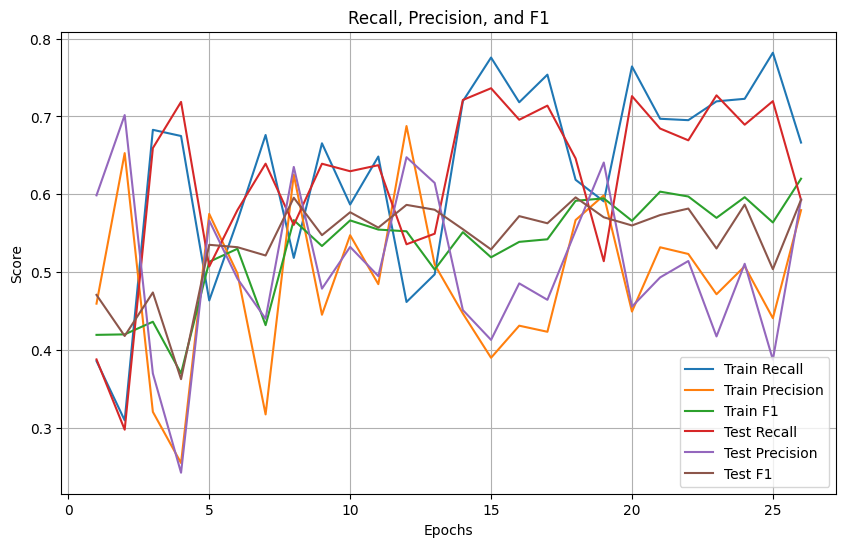

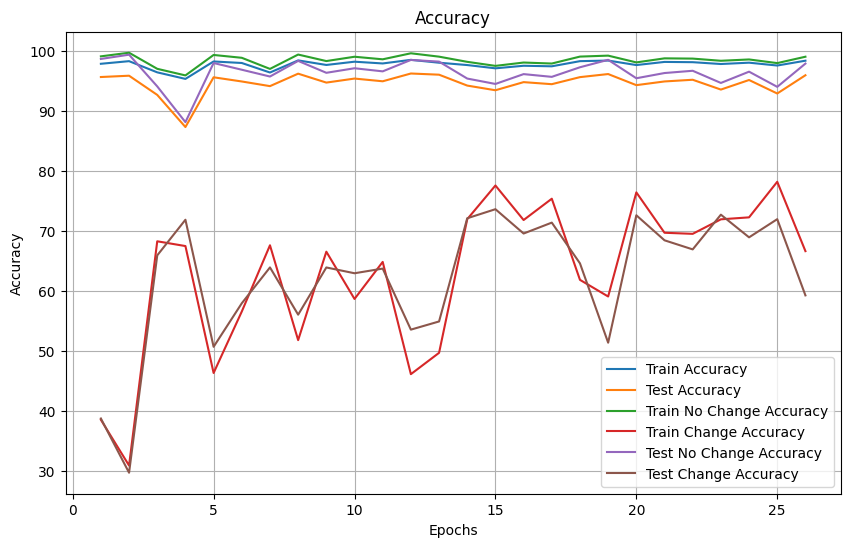

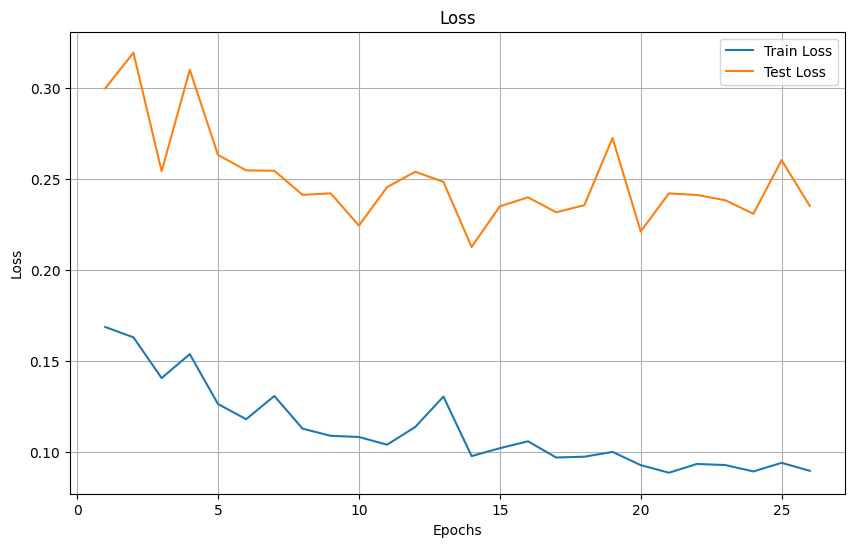

In [ ]:
# Inizializza le liste per i dati
epochs = []
train_loss = []
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_nochange_accuracy = []
train_change_accuracy = []
test_loss = []
test_accuracy = []
test_precision = []
test_recall = []
test_f1 = []
test_nochange_accuracy = []
test_change_accuracy = []

# Leggi i dati dal file CSV
with open(csv_file_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        epochs.append(int(row['Epoch']))
        train_loss.append(float(row['Train Loss']))
        train_accuracy.append(float(row['Train Accuracy']))
        train_precision.append(float(row['Train Precision']))
        train_recall.append(float(row['Train Recall']))
        train_f1.append(float(row['Train F1']))
        train_nochange_accuracy.append(float(row['Train No Change Accuracy']))
        train_change_accuracy.append(float(row['Train Change Accuracy']))
        test_loss.append(float(row['Test Loss']))
        test_accuracy.append(float(row['Test Accuracy']))
        test_precision.append(float(row['Test Precision']))
        test_recall.append(float(row['Test Recall']))
        test_f1.append(float(row['Test F1']))
        test_nochange_accuracy.append(float(row['Test No Change Accuracy']))
        test_change_accuracy.append(float(row['Test Change Accuracy']))

# Grafico di Recall, Precision ed F1
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_recall, label='Train Recall')
plt.plot(epochs, train_precision, label='Train Precision')
plt.plot(epochs, train_f1, label='Train F1')
plt.plot(epochs, test_recall, label='Test Recall')
plt.plot(epochs, test_precision, label='Test Precision')
plt.plot(epochs, test_f1, label='Test F1')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Recall, Precision, and F1')
plt.legend()
plt.grid(True)
plt.show()

# Grafico di Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
plt.plot(epochs, train_nochange_accuracy, label='Train No Change Accuracy')
plt.plot(epochs, train_change_accuracy, label='Train Change Accuracy')
plt.plot(epochs, test_nochange_accuracy, label='Test No Change Accuracy')
plt.plot(epochs, test_change_accuracy, label='Test Change Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Grafico di Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()


Caricamento a scelta di una versione del modello:

In [ ]:
nome_file = "nome-da-inserire"
net.load_state_dict(torch.load(nome_file, map_location='cpu'))

In [ ]:
def save_test_results(dset):
    for name in tqdm(dset.names):
        with warnings.catch_warnings():
            I1, I2, cm = dset.get_img(name)
            if CUDA:
              I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
              I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
            else:
              I1 = Variable(torch.unsqueeze(I1, 0).float()).cpu()
              I2 = Variable(torch.unsqueeze(I2, 0).float()).cpu()
            out = net(I1, I2)
            _, predicted = torch.max(out.data, 1)
            I = np.stack((255*cm,255*np.squeeze(predicted.cpu().numpy()),255*cm),2)
            I = np.uint8(I)
            io.imsave(f'{net_name}-{name}.png',I)
            del I1, I2, out, predicted, I
            torch.cuda.empty_cache()

t_start = time.time()
# save_test_results(train_dataset)
save_test_results(test_dataset)
t_end = time.time()
print('Elapsed time: {}'.format(t_end - t_start))

100%|██████████| 10/10 [00:37<00:00,  3.77s/it]

Elapsed time: 37.727505683898926


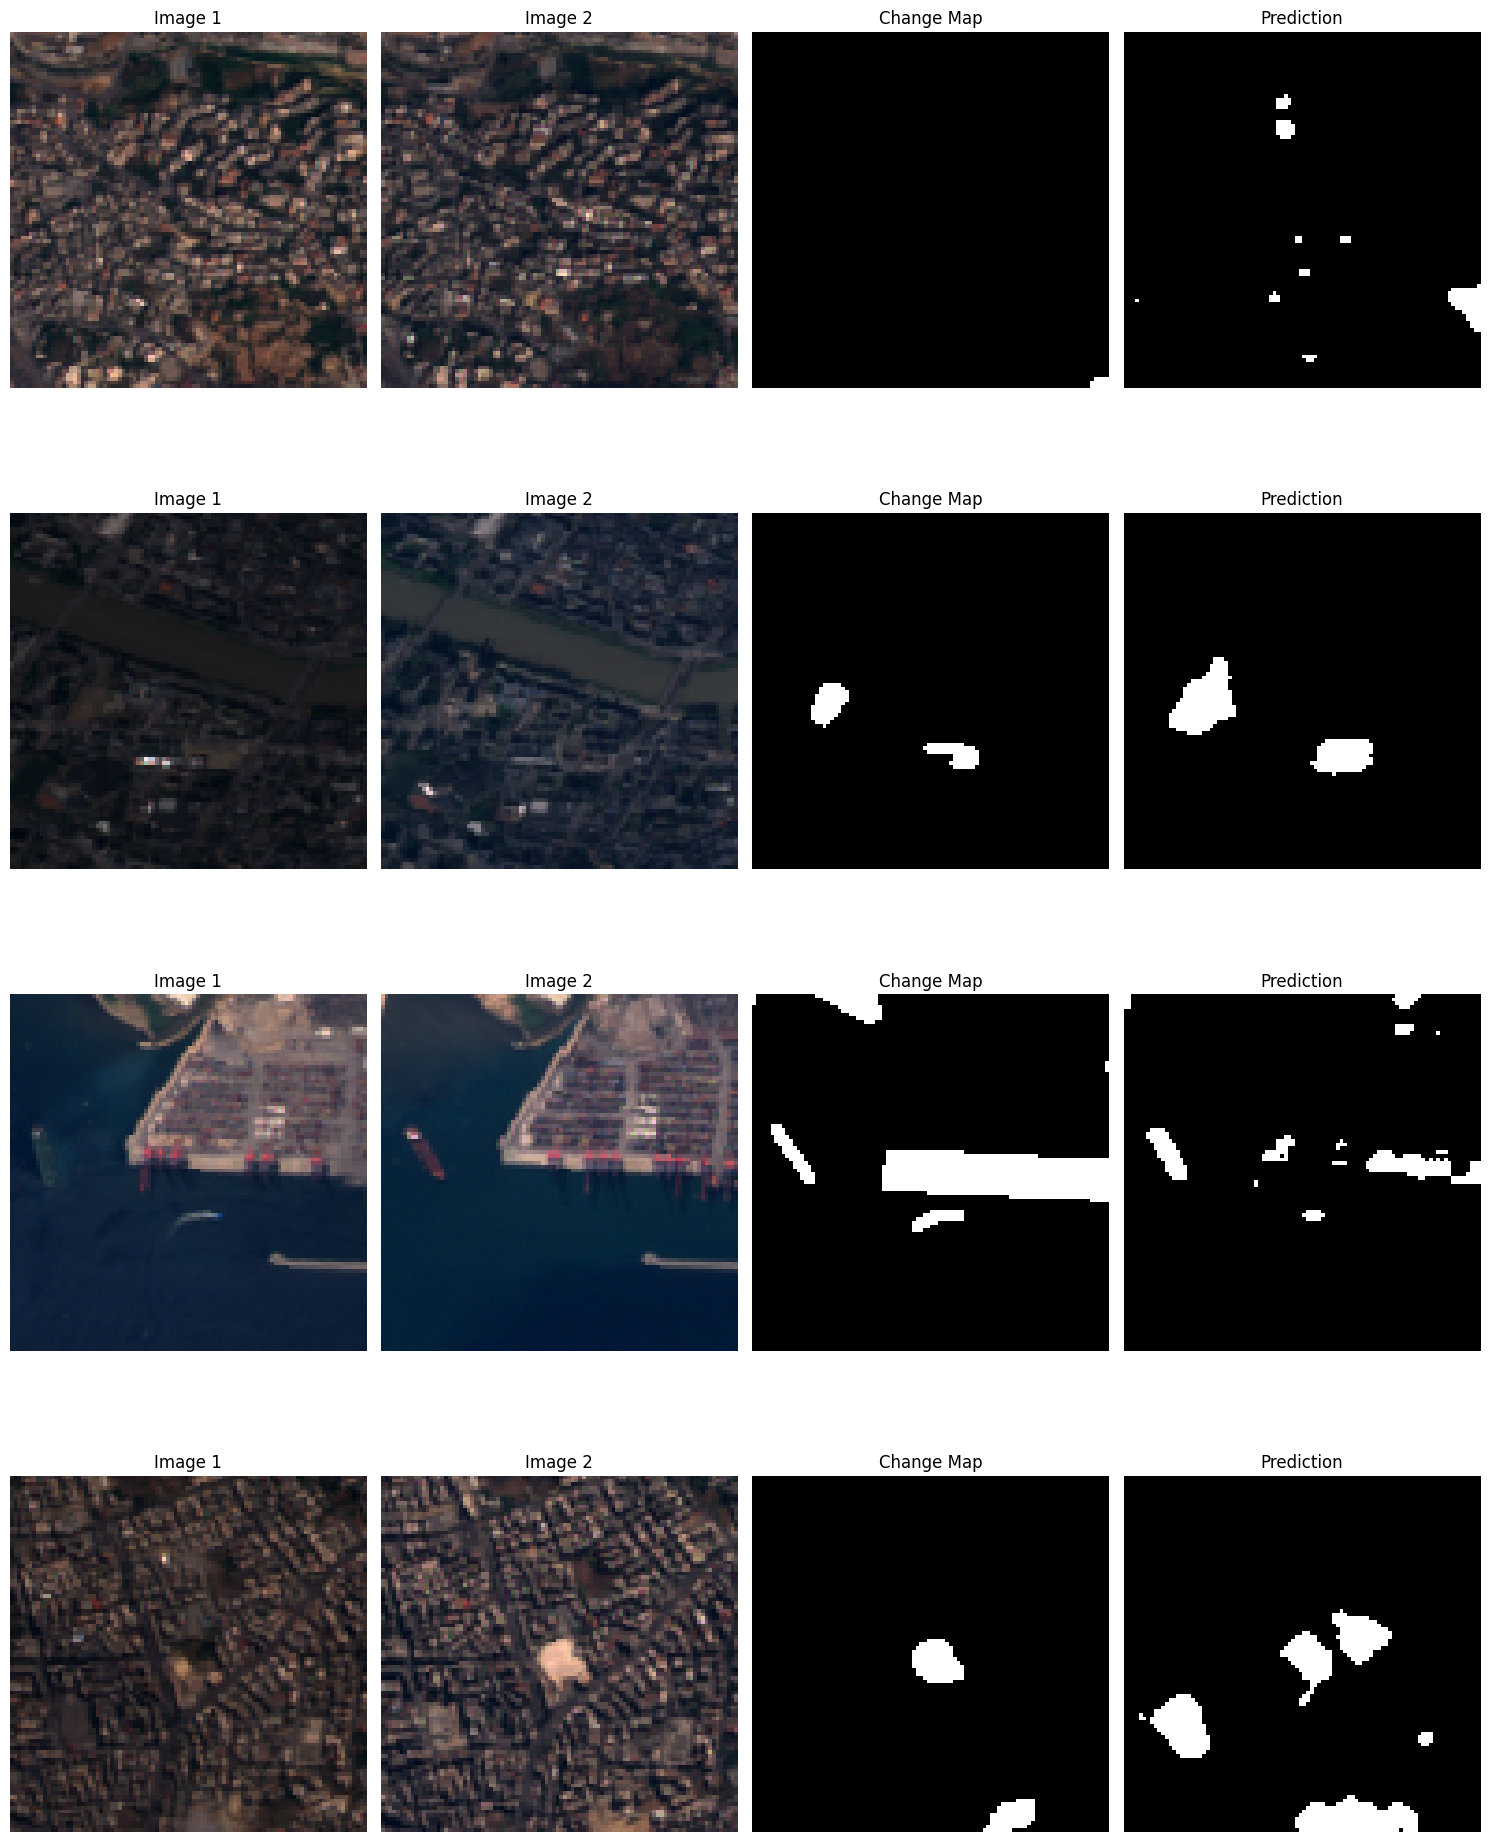

In [ ]:
import matplotlib.pyplot as plt
import random

def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

def visualize_batch(batch):
    num_samples = len(batch)
    num_rows = (num_samples + 3) // 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, 5 * num_rows))

    for i, sample in enumerate(batch):
        I1 = sample['I1']
        I2 = sample['I2']
        change_map = sample['label']

        row_idx = i // 4
        axes[row_idx, 0].imshow(normalize_image(I1[:3]).permute(1, 2, 0).numpy())
        axes[row_idx, 0].set_title('Image 1')
        axes[row_idx, 0].axis('off')

        axes[row_idx, 1].imshow(normalize_image(I2[:3]).permute(1, 2, 0).numpy())
        axes[row_idx, 1].set_title('Image 2')
        axes[row_idx, 1].axis('off')

        axes[row_idx, 2].imshow(change_map.numpy(), cmap='gray')
        axes[row_idx, 2].set_title('Change Map')
        axes[row_idx, 2].axis('off')

        # Effettua la previsione utilizzando la rete
        I1_full = Variable(I1.float()).unsqueeze(0)
        I2_full = Variable(I2.float()).unsqueeze(0)
        out = net(I1_full, I2_full)
        predicted = out.squeeze().argmax(dim=0)

        axes[row_idx,3].imshow(predicted.cpu(), cmap='gray')
        axes[row_idx,3].set_title('Prediction')
        axes[row_idx,3].axis('off')

    plt.tight_layout()
    plt.show()





# Ottenere un batch casuale dal dataset
random_indices = random.sample(range(len(train_dataset)), 16)
batch = [train_dataset[i] for i in random_indices]

# Visualizzare il batch
visualize_batch(batch)

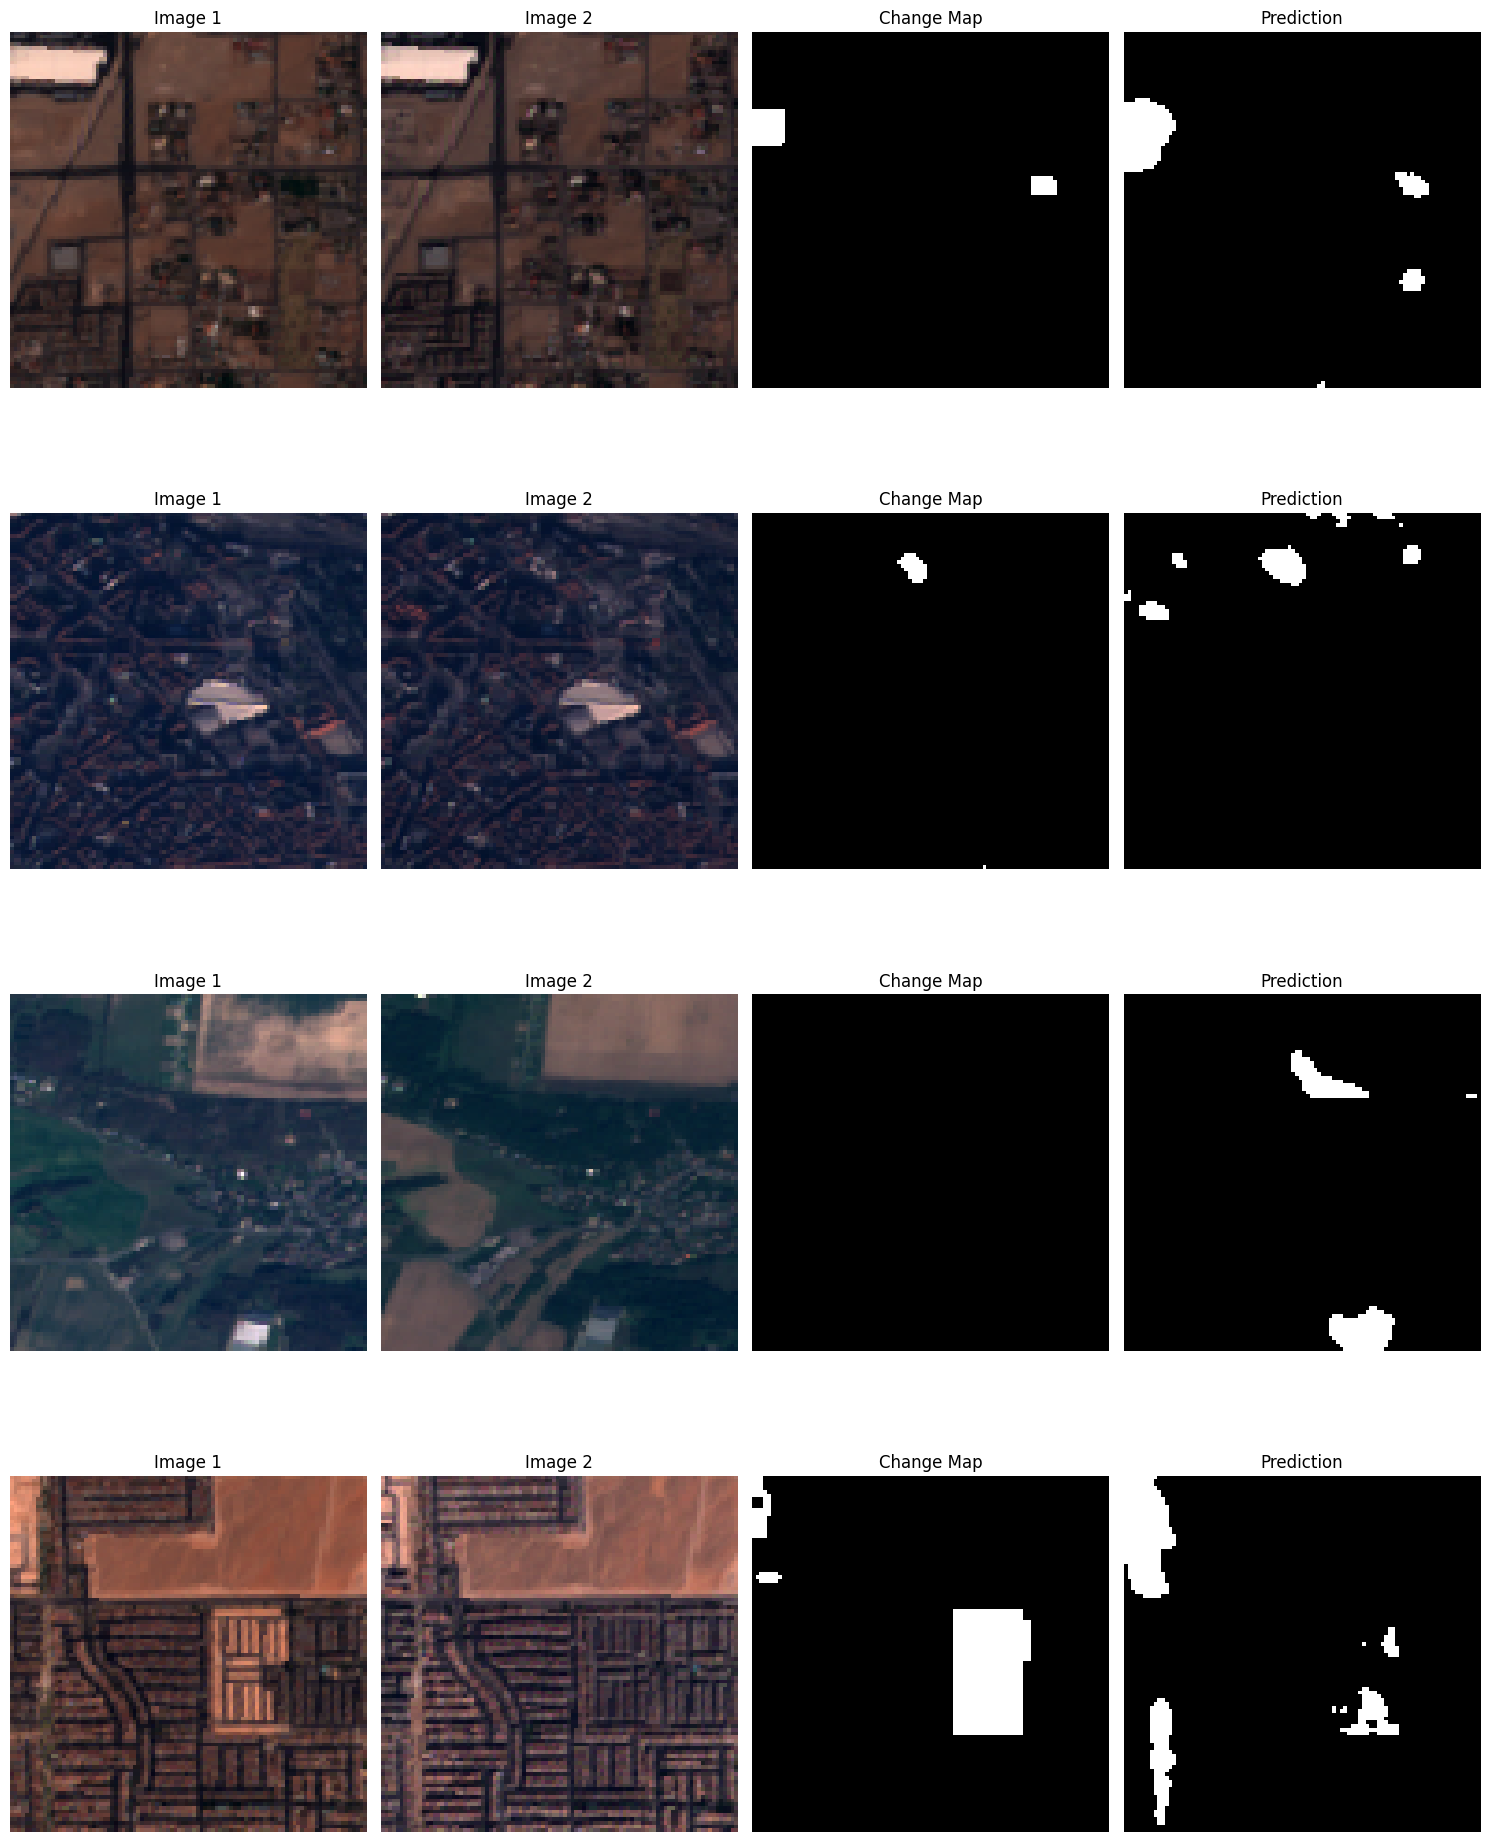

In [ ]:
random_indices = random.sample(range(len(test_dataset)), 16)
batch = [test_dataset[i] for i in random_indices]
visualize_batch(batch)


In [ ]:
L = 1024

def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)

    return (p0 - pe) / (1 - pe)

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0

    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)

        s = cm_full.shape

        for ii in range(ceil(s[0]/L)):
            for jj in range(ceil(s[1]/L)):
                xmin = L*ii
                xmax = min(L*(ii+1),s[1])
                ymin = L*jj
                ymax = min(L*(jj+1),s[1])
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]
                if CUDA:
                  I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                  I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                  cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()
                else:
                  I1 = Variable(torch.unsqueeze(I1, 0).float()).cpu()
                  I2 = Variable(torch.unsqueeze(I2, 0).float()).cpu()
                  cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cpu()

                output = net(I1, I2)

                loss = criterion(output, cm.long())
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1

                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()

                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
        torch.cuda.empty_cache()
    net_loss = tot_loss/tot_count
    net_loss = float(net_loss.cpu().numpy())

    net_accuracy = 100 * (tp + tn)/tot_count

    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)

    pr_rec = [prec, rec, dice, prec_nc, rec_nc]

    k = kappa(tp, tn, fp, fn)

    return {'net_loss': net_loss,
            'net_accuracy': net_accuracy,
            'class_accuracy': class_accuracy,
            'precision': prec,
            'recall': rec,
            'dice': dice,
            'kappa': k}

results = test(test_dataset)
pprint(results)

100%|██████████| 10/10 [01:32<00:00,  9.24s/it]

{'class_accuracy': [97.92875671386719, 59.3675651550293],
 'dice': 0.600306666479103,
 'kappa': 0.5790142752896804,
 'net_accuracy': 95.95640033814074,
 'net_loss': 0.2965329885482788,
 'precision': 0.6070874767046506,
 'recall': 0.5936756583798222}
